<a href="https://colab.research.google.com/github/RonakPandya072/Music_generation_using_DL/blob/main/Group_01_Ronak_Pandya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AID 552- Deep learning**

**Melody generation using RNN LSTM**

Group 01:Amit 
         ,Ajayan Saroj
         ,Ronak Pandya
         ,Neelkamal Malik 

**Overview**

Problem statement is to generate melody using deep learning. for that RNN and perticularly LSTM structure is used to predict the next sub-sequent notes. basically it is a time series problem wherein first we have to encode traditional musical notations (MIDI or abc notation) into numerical one and feed it into LSTM and subsequently predict the next notes which is in the numerical form. then after we have to decode the numerical values into respective notation either MIDI or abc notation. we can easily convert MIDI or abc notations into mp3 format and check the quality of the generated sound.

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json

In [ ]:
!pip install music21

In [ ]:
import numpy as np

In [ ]:
import music21 as m21

In [ ]:
import tensorflow.keras as keras

**What is Music21**

Music21 is a Python-based toolkit for computer-aided musicology developed by MIT researchers.  
People use music21 to answer questions from musicology using computers, to study large datasets of music, to generate musical examples, to teach fundamentals of music theory, to edit musical notation, study music and the brain, and to compose music


**About Dataset**

Dataset we have used in the project is from kern.humdrum.org which is open source dataset of virtual music scores in .krn data format. The dataset contains around 7,866,496 notes in 108,703 files. Dataset is also well classified according to composers and genres. To know more about each and every song and its origin, composer, type of the song etc. visit https://kern.humdrum.org/help/data/

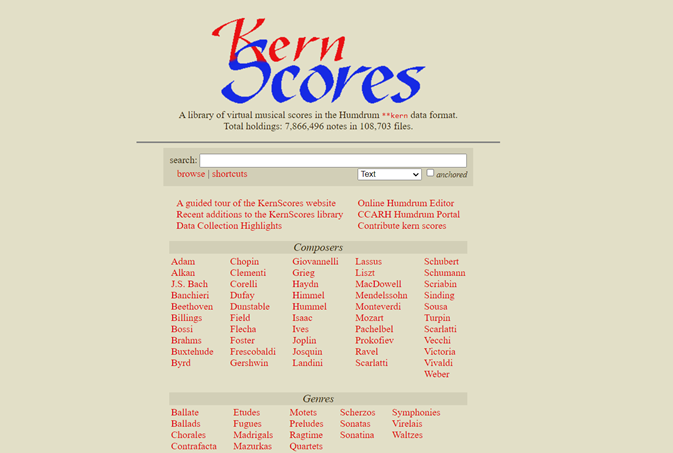

dataset: https://kern.humdrum.org/cgi-bin/browse?l=essen%2Feuropa%2Fdeutschl

In [ ]:
!wget --header="Host: kern.humdrum.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://kern.humdrum.org/cgi-bin/browse?l=essen%2Feuropa%2Fdeutschl" "https://kern.humdrum.org/cgi-bin/ksdata?l=essen/europa/deutschl&format=recursive" -c -O 'deutschl.zip'

--2022-04-08 06:16:42--  https://kern.humdrum.org/cgi-bin/ksdata?l=essen/europa/deutschl&format=recursive
Resolving kern.humdrum.org (kern.humdrum.org)... 171.67.229.81
Connecting to kern.humdrum.org (kern.humdrum.org)|171.67.229.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘deutschl.zip’

deutschl.zip            [   <=>              ]   3.19M  6.39MB/s    in 0.5s    

2022-04-08 06:16:52 (6.39 MB/s) - ‘deutschl.zip’ saved [3342270]



In [ ]:
!unzip '/content/deutschl.zip' #unzipping the dataset

Streaming output truncated to the last 5000 lines.
  inflating: essen/europa/deutschl/zuccal/deut5063.krn  
  inflating: essen/europa/deutschl/zuccal/deut4683.krn  
  inflating: essen/europa/deutschl/zuccal/deut4598.krn  
  inflating: essen/europa/deutschl/zuccal/deut4638.krn  
  inflating: essen/europa/deutschl/zuccal/deut4929.krn  
  inflating: essen/europa/deutschl/zuccal/deut4608.krn  
  inflating: essen/europa/deutschl/zuccal/deut5067.krn  
  inflating: essen/europa/deutschl/zuccal/deut4567.krn  
  inflating: essen/europa/deutschl/zuccal/deut4615.krn  
  inflating: essen/europa/deutschl/zuccal/deut4959.krn  
  inflating: essen/europa/deutschl/zuccal/deut5106.krn  
  inflating: essen/europa/deutschl/zuccal/deut4597.krn  
  inflating: essen/europa/deutschl/zuccal/deut4738.krn  
  inflating: essen/europa/deutschl/zuccal/deut4706.krn  
  inflating: essen/europa/deutschl/zuccal/deut4847.krn  
  inflating: essen/europa/deutschl/zuccal/deut4778.krn  
  inflating: essen/europa/deutschl/zu

**About nodes in music theory**

An eighth note (American) or a quaver (British) is a musical note played for one eighth the duration of a whole note (semibreve), hence the name. This amounts to twice the value of the sixteenth note (semiquaver). It is half the duration of a quarter note (crotchet), one quarter the duration of a half note (minim), one eighth the duration of a whole note (semibreve), one-sixteenth the duration of a double whole note (breve), and one thirty-second the duration of a longa.

A whole note (American) or semibreve (British) in musical notation is a single note equivalent to or lasting as long as two half-notes or four quarter-notes.

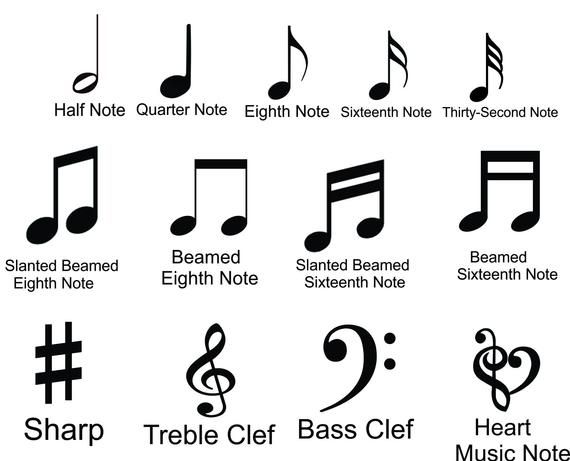

**MIDI representation**

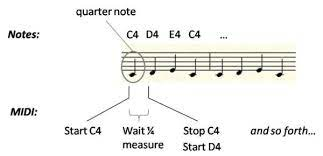

**abc notation**

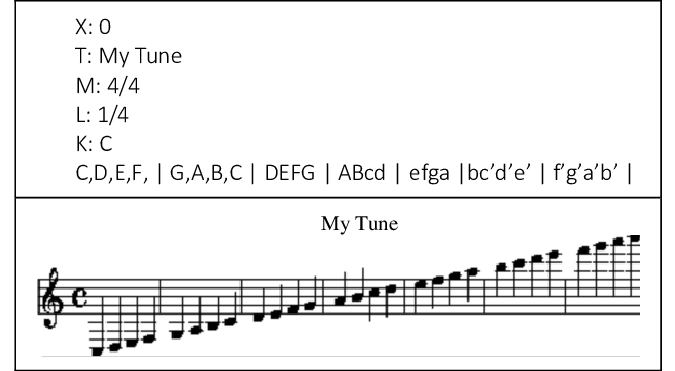

In [ ]:
!mkdir S_dataset #creating a folder

In [ ]:
!touch file_dataset #creating a file

In [ ]:
DATASET_PATH = '/content/essen/europa/deutschl/erk'
SAVE_PATH = '/content/S_dataset'
SINGLE_FILE = '/content/file_dataset'
mapping_path="mapping.json"
sequence_length = 64
ACCEPTABLE_DURATION=[0.25,0.5,0.75,1,1.5,2,3,4] #represent accaptable 8 node duration

**Keys in the Music theory**

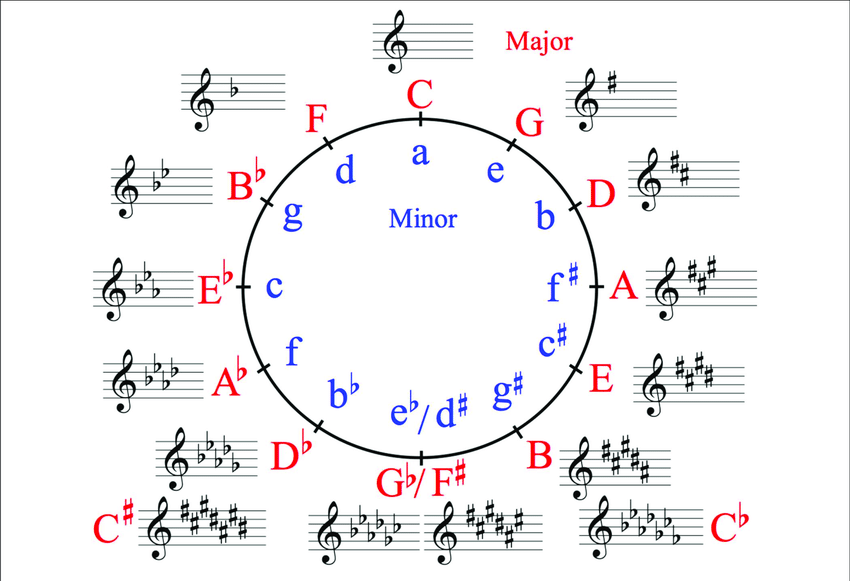

In [ ]:

def load_music(file_path):
    #go through all the files in the dataset and loading the data using music21
    songs = []
    for path, subdirs, files in os.walk(file_path):
        for file in files:
            if file[-3:] == 'krn':
                song = m21.converter.parse(os.path.join(path,file))
                songs.append(song)
    return songs

def acceptable_song(song, acceptable_durations):
    for note in song.flat.notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

def transpose(song):
  #get key from music
  parts = song.getElementsByClass(m21.stream.Part)
  measure_part0=parts[0].getElementsByClass(m21.stream.Measure)
  key = measure_part0[0][4]

  #estimate key from music21
  if not isinstance(key, m21.key.Key):
    key = song.analyze("key")
    print(key)

  #get interval of transformation #E.G. Bmaj-->Cmaj
  if key.mode =='major':
    interval=m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
  elif key.mode =='minor':
    interval=m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))

  #transpose song by calculated interval
  transposed_song = song.transpose(interval)

  return transposed_song

def encode_song(song, time_step = 0.25):
   #p = 60, d = 1.0 -> [60, "_", "_", "_"]
   encoded_song=[]
   for event in song.flat.notesAndRests:
     #handle notes
     if isinstance(event, m21.note.Note):
       symbol = event.pitch.midi  #60
        #handle rest
     elif isinstance(event, m21.note.Rest):
       symbol = "r"

      #convert the note/rest into Timeseries pattern
     steps = int(event.duration.quarterLength/time_step)
     for step in range(steps):
       if step == 0:
         encoded_song.append(symbol)
       else:
         encoded_song.append("_")

    #cast encoded song into str
   encoded_song = " ".join(map(str,encoded_song))

   return encoded_song

In [ ]:
def preprocessing(file_path):
    #load the file
    print('Loading songs....')
    songs = load_music(file_path)
    print(f"loaded {len(songs)} files")

    for i, song in enumerate(songs):
      #filter out non acceptable duration
      if not acceptable_song(song, ACCEPTABLE_DURATION):
        continue
      #transpose the song to Cmaj/Amin
      song = transpose(song)

      #encode the song with music time series representation
      enc_song = encode_song(song)

      #save a song to text file
      save_path = os.path.join(SAVE_PATH,str(i))
      
      with open(save_path, "w") as fp:
        fp.write(enc_song)

In [ ]:
def load(file_path):
  with open(file_path,"r") as fp:
    song = fp.read()
  return song

In [ ]:
def create_single_file_dataset(SAVE_PATH, SINGLE_FILE, sequence_length):
  new_song_delimiter = "/ "*sequence_length
  songs = ""
  #load encoded songs and add delimiters
  for path, _, files in os.walk(SAVE_PATH):
    for file in files:
      file_path = os.path.join(path,file)
      song = load(file_path)
      songs = songs+song+" "+new_song_delimiter
  song = songs[:-1]

  #save string that contains dataset
  with open(SINGLE_FILE, "w") as fp:
    fp.write(songs)
  
  return songs

In [ ]:
def create_mapping(songs, mapping_path):
  mapping={}
  #identify the vocabulary
  songs = songs.split()
  vocabulary = list(set(songs))
  #create a mapping
  for i, symbol in enumerate(vocabulary):
    mapping[symbol] = i

  #save into json file
  with open(mapping_path,"w") as fp:
    json.dump(mapping, fp, indent=4)

In [ ]:
song = load_music(DATASET_PATH)

In [ ]:
ans=acceptable_song(song[1], ACCEPTABLE_DURATION)
print(ans)

True


In [ ]:
transposed_song = transpose(song[0])

In [ ]:
preprocessing(DATASET_PATH)

Loading songs....
loaded 1700 files


In [ ]:
songs = create_single_file_dataset(SAVE_PATH,SINGLE_FILE, sequence_length)

In [ ]:
create_mapping(songs,mapping_path)

In [ ]:
def convert_songs_to_int(songs):
    int_songs = []

    # load mappings
    with open(mapping_path, "r") as fp:
        mappings = json.load(fp)

    # transform songs string to list
    songs = songs.split()

    # map songs to int
    for symbol in songs:
        int_songs.append(mappings[symbol])

    return int_songs

In [ ]:
def generate_training_sequences(sequence_length):
    """Create input and output data samples for training. Each sample is a sequence.
    :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars
    :return inputs (ndarray): Training inputs
    :return targets (ndarray): Training targets
    """

    # load songs and map them to int
    songs = load(SINGLE_FILE)
    int_songs = convert_songs_to_int(songs)

    inputs = []
    targets = []

    # generate the training sequences
    num_sequences = len(int_songs) - sequence_length
    for i in range(num_sequences):
        inputs.append(int_songs[i:i+sequence_length])
        targets.append(int_songs[i+sequence_length])

    # one-hot encode the sequences
    vocabulary_size = len(set(int_songs))
    # inputs size: (# of sequences, sequence length, vocabulary size)
    inputs = keras.utils.to_categorical(inputs, num_classes=vocabulary_size)
    targets = np.array(targets)

    return inputs, targets


In [ ]:
def main():
    preprocessing(DATASET_PATH)
    songs = create_single_file_dataset(SAVE_PATH, SINGLE_FILE, sequence_length)
    create_mapping(songs, mapping_path)
    inputs, targets = generate_training_sequences(sequence_length)


if __name__ == "__main__":
    main()

Loading songs....
loaded 1700 files


##                 **********    PART-2  *********

In [ ]:
# import tensorflow.keras as keras
# from preprocessing import generate_training_sequences, sequence_length

OUTPUT_UNITS = 38
NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001
EPOCHS = 1
BATCH_SIZE = 64
SAVE_MODEL_PATH = "model.h5"

def build_model(output_units, num_units, loss, learning_rate):

    # create the model architecture
    input = keras.layers.Input(shape=(None, output_units))
    x = keras.layers.LSTM(num_units[0])(input)
    x = keras.layers.Dropout(0.2)(x)

    output = keras.layers.Dense(output_units, activation="softmax")(x)

    model = keras.Model(input, output)

    # compile model
    model.compile(loss=loss,optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=["accuracy"])
    model.summary()

    return model


def train(output_units=OUTPUT_UNITS, num_units=NUM_UNITS, loss=LOSS, learning_rate=LEARNING_RATE):

    # generate the training sequences
    inputs, targets = generate_training_sequences(sequence_length)

    # build the network
    model = build_model(output_units, num_units, loss, learning_rate)

    # train the model
    model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)

    # save the model
    model.save(SAVE_MODEL_PATH)


if __name__ == "__main__":
    train()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 38)]        0         
                                                                 
 lstm (LSTM)                 (None, 256)               302080    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 38)                9766      
                                                                 
Total params: 311,846
Trainable params: 311,846
Non-trainable params: 0
_________________________________________________________________
5660/5660 [==============================] - 131s 22ms/step - loss: 0.6862 - accuracy: 0.7894


In [ ]:
class MelodyGenerator:
  
  def __init__(self, model_path="model.h5"):
    self.model_path = model_path
    self.model = keras.models.load_model(model_path)

    with open(mapping_path,'r')as fp:
      self._mappings=json.load(fp)
    self._start_symbols = ["/"]*sequence_length

  def generate_melody(self, seed, num_steps, max_sequence_length, temperature):
    #create seed with start symbols
    seed = seed.split()
    melody = seed
    seed = self._start_symbols + seed

    #mapping seed to int
    seed = [self._mappings[symbol] for symbol in seed]
    for _ in range(num_steps):
      #limit the seed to max_sequence_length
      seed = seed[-max_sequence_length:]

      #one hot encode the seed
      one_hot_seed = keras.utils.to_categorical(seed, num_classes = len(self._mappings))
      #size of one_hot_seed = (max_sequence_length, num of smbols in vocabulary)
      one_hot_seed =one_hot_seed[np.newaxis, ...]
      #It addes extra dimensions because keras takes input in batch, so we have to add third dimension 
      #... indicates it will take all the other dimension from one_hot_seed
      #final shape--> (1,max_sequence_length, num of smbols in vocabulary)

      #make prediction
      probabilities = self.model.predict(one_hot_seed)[0]
      output_int = self._sample_with_temperature(probabilities, temperature)

      #update the seed
      seed.append(output_int)

      #map int to encoding
      output_symbol=[k for k,v in self._mappings.items() if v == output_int][0]

      #check whether we're at the end of a melody
      if output_symbol == '/':
        break
      
      #update the melody
      melody.append(output_symbol)

    return melody

  def _sample_with_temperature(self,probability, temperature):
    #temperature --> infinite, distribution becomes homogeneous distribution, randomly picking variable having same probability
    #temperature -- > 0, original highest probability variables becomes highly deterministic and it's probability is equal to 1
    #temperature --> 1, best case, normal sampling
    predictions = np.log(probability)/temperature
    probability = np.exp(predictions)/np.sum(np.exp(predictions))

    choices = range(len(probability)) 
    index = np.random.choice(choices, p=probability)

    return index

  # def save_melody(self, melody,step_duration=0.25, format='midi', file_name='mel.midi'):

  #   #converts list melody list to MIDI
  #   #create a music21 stream


  #   #parse all symbols in the melody in the melody and crea


  def save_melody(self, melody, step_duration=0.25, format="midi", file_name="mel.mid"):

        # create a music21 stream
        stream = m21.stream.Stream()

        start_symbol = None
        step_counter = 1

        # parse all the symbols in the melody and create note/rest objects
        for i, symbol in enumerate(melody):

            # handle case in which we have a note/rest
            if symbol != "_" or i + 1 == len(melody):

                # ensure we're dealing with note/rest beyond the first one
                if start_symbol is not None:

                    quarter_length_duration = step_duration * step_counter # 0.25 * 4 = 1

                    # handle rest
                    if start_symbol == "r":
                        m21_event = m21.note.Rest(quarterLength=quarter_length_duration)

                    # handle note
                    else:
                        m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)

                    stream.append(m21_event)

                    # reset the step counter
                    step_counter = 1

                start_symbol = symbol

            # handle case in which we have a prolongation sign "_"
            else:
                step_counter += 1

        # write the m21 stream to a midi file
        stream.write(format, file_name)

In [ ]:
mg = MelodyGenerator()
seed = "60 _ 62 _ 64 _ 65 _ 67"
melody = mg.generate_melody(seed,500, sequence_length,0.7)
print(melody)
print(type(melody))

['60', '_', '62', '_', '64', '_', '65', '_', '67', '_', '_', '_', '67', '_', '64', '_', '64', '_', '_', '_', '67', '_', '_', '_', '67', '_', '_', '_', '64', '_', '_', '_', '65', '_', '_', '_', '64', '_', '_', '_', '64', '_', '_', '_', '62', '_', '_', '_', '69', '_', '_', '_', '69', '_', '_', '_', '_', '_', '66', '_', '64', '_', '_', '_', '_', '_', '_', '_', 'r', '_', '_', '_']
<class 'list'>


In [ ]:
mg.save_melody(melody)

In [ ]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

In [ ]:
from midi2audio import FluidSynth

In [ ]:
Music = FluidSynth(sound_font='/content/drive/MyDrive/Electric Piano 1.sf2')

In [ ]:
help(FluidSynth())

Help on FluidSynth in module midi2audio object:

class FluidSynth(builtins.object)
 |  FluidSynth(sound_font='~/.fluidsynth/default_sound_font.sf2', sample_rate=44100)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sound_font='~/.fluidsynth/default_sound_font.sf2', sample_rate=44100)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  midi_to_audio(self, midi_file, audio_file)
 |  
 |  play_midi(self, midi_file)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [ ]:
Music.midi_to_audio('mel.mid','mel_1.mp3')

In [ ]:
Music.play_midi('mel_1.mp3')

In [ ]:
!pip install IPython

In [ ]:
from IPython.display import Audio

In [ ]:
Music = '/content/mel_1.mp3'

In [ ]:
Audio(data=Music,autoplay=False)